In [1]:
import os
import tweepy as tw
import pandas as pd
import numpy as np
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
#pd.pandas.set_option("display.max_rows",None)
#pd.pandas.set_option("display.max_columns",None)

# Defining Keys To Extract Tweets

In [2]:
consumer_key= 'KJDaXnGILUPvXWzRsfqRTkhS4'
consumer_secret= 'slDfuX2IlZVNq1YULlQmDb0SFt5Mwd7OXg7c4kcDlTmoC9j2Gi'

access_token= '957674462354296832-DWy0VORcotEOQUDOLuaXLK5EoTkpoeY'
access_token_secret= 'UldzES3dvBEjhILM3oguMK8dmbeeQejnpxKMjXyVRCisC'

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)

auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth, wait_on_rate_limit=True)



In [4]:
search_words = "#امپورٹڈ_حکومت_نامنظور"
date_since = "2022-04-09"

In [ ]:
tweets = tw.Cursor(api.search_tweets,
              q=search_words,
              lang="en"
              ).items(2000)
tweets

In [ ]:
data=[]

for i in tweets:
    final_text=i.text.replace('RT','')
    if(final_text.startswith(' @')):
        position=final_text.index(':')
        final_text=final_text[position+2:]
        
    if(final_text.startswith('@')):
        position=final_text.index(' ')
        final_text=final_text[position+1:]
           
    data.append(final_text)
 
  
        
    print(final_text)

# Making a DataFrame of all the Retrieved Tweets

In [ ]:
data = pd.DataFrame(data=data, 
                    columns=["Tweet Text"])
data.to_csv('tweet_text.csv')

In [2]:
data=pd.read_csv("tweet_text.csv")

In [3]:
data

,Unnamed: 0,Tweet Text
0,0,Leaders Must be close enough to relate to othe...
1,1,Leaders Must be close enough to relate to othe...
2,2,Leaders Must be close enough to relate to othe...
3,3,I am New on Twitter Plz Follow Me 😁\n@amalqa_\...
4,4,"Chairman PTI @ImranKhanPTI earlier today, in B..."
...,...,...
995,995,Expected performance of Imported Cabinat will ...
996,996,Reached Lahore \n\n#امپورٹڈ_حکومت_نامنظور
997,997,A professional man like Dr Faisal Sultan is re...
998,998,Qadir Patel was arrested for working with Uzai...


In [4]:
data=data.drop(["Unnamed: 0"],axis="columns")


In [5]:
data

,Tweet Text
0,Leaders Must be close enough to relate to othe...
1,Leaders Must be close enough to relate to othe...
2,Leaders Must be close enough to relate to othe...
3,I am New on Twitter Plz Follow Me 😁\n@amalqa_\...
4,"Chairman PTI @ImranKhanPTI earlier today, in B..."
...,...
995,Expected performance of Imported Cabinat will ...
996,Reached Lahore \n\n#امپورٹڈ_حکومت_نامنظور
997,A professional man like Dr Faisal Sultan is re...
998,Qadir Patel was arrested for working with Uzai...


# Filtering Tweets to remove Emoji's etc

In [6]:
from bs4 import BeautifulSoup
import unicodedata
import re
def clean_text(text):
    
    text=re.sub(r'@[A-Za-z0-9]+', '',text) # remove @ mentions
    text=re.sub(r'#', '',text)  #remove # symbols  
    #text=re.sub(r'#[A-Za-z0-9]+', '',text)  #
    text=re.sub(r'RT[\S]+', '',text) # Removing RT
    text=re.sub(r'\bRT\b',"",text).strip() # Remove RT
    
    text=re.sub(r'\bRT\b',"",text).strip()# Removing RT
    text=re.sub(r'https?:\/\/\S+', '',text)# Removes hyperlinks
    text=' '.join(text.split()) # remove spaces
    
    
    text=re.sub(r'\n','',text)
    text=re.sub(r'__','',text)
    text=re.sub(r'_','',text)
   
    text=re.sub(r'|','',text)
    text=re.sub(r'[^\w ]+',"",text)
    text= re.sub(r'\d+', '', text) # remove numbers
    text = text.encode("ascii", "ignore").decode() #remove emojis
    
    text=re.sub(r'([A-Za-z0-9+._-]+@[A-Za-z0-9+._-]+\.[A-Za-z0-9+_-]+)',"",text) # remove Emails
    text=BeautifulSoup(text, 'lxml').get_text().strip()  #Remove HTML TAGS
    text=unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8','ignore')  #remove accented characters
    text=re.sub(r'[^\w ]+',"",text)  # Remove Special Characters ...,,,@\\
    
    text=' '.join(text.split()) #Removing Extra Spaces and Gapes
    
    
    return text

In [7]:
data["Tweet Text"]=data["Tweet Text"].apply(clean_text)
data

,Tweet Text
0,Leaders Must be close enough to relate to othe...
1,Leaders Must be close enough to relate to othe...
2,Leaders Must be close enough to relate to othe...
3,I am New on Twitter Plz Follow Me
4,Chairman PTI earlier today in Bani Gala Imran ...
...,...
995,Expected performance of Imported Cabinat will ...
996,Reached Lahore
997,A professional man like Dr Faisal Sultan is re...
998,Qadir Patel was arrested for working with Uzai...


# REMOVING STOPWORDS 

In [8]:
data["Tweet Text"]=data["Tweet Text"].apply(lambda x: ' '.join([i for i in x.split() if i not in stopwords]))

# Convert words into its Root Form

In [9]:
import en_core_web_sm

nlp=spacy.load("en_core_web_sm")

def base_conversion(x):
    x=str(x)
    x_list=[]
    doc=nlp(x)
    
    for token in doc:
        lemma=token.lemma_
        if(lemma=='-PRON-' or lemma== 'be'):
            lemma=token.text
        x_list.append(lemma)
    return ' '.join(x_list)

In [10]:
data["Tweet Text"]=data["Tweet Text"].apply(lambda x: base_conversion(x))

# 20 Common Words Removal (Most frequent words Removal)

In [11]:
text=' '.join(data["Tweet Text"])
text=text.split()

# finding frequency of words repeated the most

freq_common=pd.Series(text).value_counts()
# selecting top 20 words that are the most commonly occured in the dataset
f20=freq_common[:20]

data["Tweet Text"]=data["Tweet Text"].apply(lambda x: ' '.join([i for i in x.split() if i not in f20 ]))

# Rare Occuring Words Removal

In [12]:
text=' '.join(data["Tweet Text"])
text=text.split()

freq_common=pd.Series(text).value_counts()
# selecting top 20 words that are the most commonly occured in the dataset
rare20=freq_common.tail(20)

data["Tweet Text"]=data["Tweet Text"].apply(lambda x: ' '.join([i for i in x.split() if i not in rare20 ]))

# Tweets Tokenized into words

In [13]:
#defining function for tokenization
import re
def tokenization(text):
    tokens = re.split('\\W+',text)
    return tokens
#applying function to the column
data['Tokenized_tweets']= data['Tweet Text'].apply(lambda x: tokenization(x))

In [14]:
data

,Tweet Text,Tokenized_tweets
0,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,..."
1,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,..."
2,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,..."
3,New Twitter plz follow,"[New, Twitter, plz, follow]"
4,Chairman PTI early today Bani Gala Peshawar to...,"[Chairman, PTI, early, today, Bani, Gala, Pesh..."
...,...,...
995,expect performance Imported Garbage garbage,"[expect, performance, Imported, Garbage, garbage]"
996,reach Lahore,"[reach, Lahore]"
997,Kis baat banda rona roye,"[Kis, baat, banda, rona, roye]"
998,arrest work Uzair Baloch Asim charge corruptio...,"[arrest, work, Uzair, Baloch, Asim, charge, co..."


# Polarity and Subjectivity of Tweets

In [15]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_Polarity(text):
    return TextBlob(text).sentiment.polarity

data["Subjectivity"]=data["Tweet Text"].apply(get_subjectivity)
data["Polarity"]=data["Tweet Text"].apply(get_Polarity)

In [16]:
data

,Tweet Text,Tokenized_tweets,Subjectivity,Polarity
0,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,...",1.000000,0.100000
1,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,...",1.000000,0.100000
2,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,...",1.000000,0.100000
3,New Twitter plz follow,"[New, Twitter, plz, follow]",0.454545,0.136364
4,Chairman PTI early today Bani Gala Peshawar to...,"[Chairman, PTI, early, today, Bani, Gala, Pesh...",0.300000,0.100000
...,...,...,...,...
995,expect performance Imported Garbage garbage,"[expect, performance, Imported, Garbage, garbage]",0.000000,0.000000
996,reach Lahore,"[reach, Lahore]",0.000000,0.000000
997,Kis baat banda rona roye,"[Kis, baat, banda, rona, roye]",0.000000,0.000000
998,arrest work Uzair Baloch Asim charge corruptio...,"[arrest, work, Uzair, Baloch, Asim, charge, co...",0.000000,-0.050000


# Analyzing Tweets Negative or Positive or Neutral

In [17]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
data["Analysis"]=data["Polarity"].apply(getAnalysis)

# Counting Neutral or Positive or Negative Tweets

In [18]:
data["Analysis"].value_counts()

Neutral     599
Positive    288
Negative    113
Name: Analysis, dtype: int64

In [19]:
data

,Tweet Text,Tokenized_tweets,Subjectivity,Polarity,Analysis
0,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,...",1.000000,0.100000,Positive
1,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,...",1.000000,0.100000,Positive
2,leader must close relate but far ahead motivat...,"[leader, must, close, relate, but, far, ahead,...",1.000000,0.100000,Positive
3,New Twitter plz follow,"[New, Twitter, plz, follow]",0.454545,0.136364,Positive
4,Chairman PTI early today Bani Gala Peshawar to...,"[Chairman, PTI, early, today, Bani, Gala, Pesh...",0.300000,0.100000,Positive
...,...,...,...,...,...
995,expect performance Imported Garbage garbage,"[expect, performance, Imported, Garbage, garbage]",0.000000,0.000000,Neutral
996,reach Lahore,"[reach, Lahore]",0.000000,0.000000,Neutral
997,Kis baat banda rona roye,"[Kis, baat, banda, rona, roye]",0.000000,0.000000,Neutral
998,arrest work Uzair Baloch Asim charge corruptio...,"[arrest, work, Uzair, Baloch, Asim, charge, co...",0.000000,-0.050000,Negative


# Visualizing Tweets 

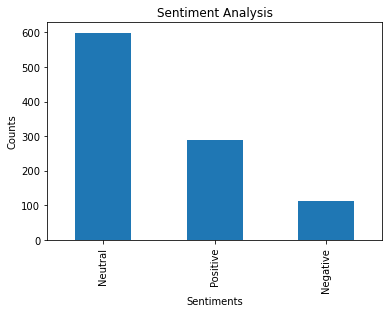

In [57]:
import matplotlib.pyplot as plt
ptweets=data[data.Analysis=='Positive']
ptweets=ptweets['Tweet Text']
round((ptweets.shape[0]/data.shape[0])*100,1)
## get percentage of negative tweets
ntweets=data[data.Analysis=='Negative']
round((ntweets.shape[0]/data.shape[0])*100,1)
## show value counts
data['Analysis'].value_counts()
## plot visulatisation of count
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments') 
plt.ylabel('Counts')
data['Analysis'].value_counts().plot(kind='bar')
plt.show()

# Words Cloud Visualization

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

text=' '.join(data["Tweet Text"])
len(text)

wc=WordCloud(width=800, height=400).generate(text)
plt.imshow(wc)
plt.axis("off")
plt.show()

# Feature Engineering

In [20]:

x1=data["Tweet Text"]
y=data["Analysis"]


# Vectorizing Text to Vectors

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
x=vectorizer.fit_transform(x1)

features_names=vectorizer.get_feature_names()

In [23]:
len(features_names)

1476

+ Converting Vectorized Data to Array because Model doesn't Understands Sparse Matrix Data generated from TFID Vectorizer

In [24]:
x=x.toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
x.shape


(1000, 1476)

In [26]:
data2 = pd.DataFrame(data=x,columns=features_names)
x=data2
x

,aamir,ab,abbasi,abdul,abdur,able,absolutely,accept,acceptable,access,...,yesterday,you,your,youth,zafar,zaidi,zardari,zartaj,zindabad,zubair
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Smote method to Balance data

In [27]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [28]:
y.value_counts()

Neutral     599
Positive    599
Negative    599
Name: Analysis, dtype: int64

# Splitting Data into Train and Test

In [29]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,train_size=0.80)


In [30]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif,mutual_info_regression
from sklearn.feature_selection import SelectKBest,SelectPercentile

In [31]:
x_train.shape

(1437, 1476)

# Constant Features Removal

In [32]:
const_filter=VarianceThreshold(threshold=0)
const_filter.fit(x_train)

VarianceThreshold(threshold=0)

In [33]:
# After removing of constant features from training set
const_filter.get_support().sum()

1411

In [34]:
#columns that were constants

constant_features=[not temp for temp in const_filter.get_support()]

len(x.columns[constant_features])

65

In [35]:
# remove all constant features from dataset

x_train_filtered=const_filter.transform(x_train)
x_test_filtered=const_filter.transform(x_test)
x_train_filtered.shape


(1437, 1411)

In [36]:
# Comparing
x_train_filtered.shape,x_train.shape

((1437, 1411), (1437, 1476))

# Removing Duplicates Features

In [37]:
x_train_dupl=x_train_filtered.T
x_test_dupl=x_test_filtered.T

In [38]:
type(x_train_dupl)

numpy.ndarray

In [39]:
x_train_dupl=pd.DataFrame(x_train_dupl)
x_test_dupl=pd.DataFrame(x_test_dupl)

In [40]:
#Duplicated Features
duplicate_features=x_train_dupl.duplicated()
duplicate_features

0       False
1       False
2       False
3       False
4       False
        ...  
1406     True
1407    False
1408     True
1409     True
1410    False
Length: 1411, dtype: bool

In [41]:
#Features not Duplicated

features_to_keep=[not index for index in duplicate_features]

In [42]:
x_train_final=x_train_dupl[features_to_keep].T
x_test_final=x_test_dupl[features_to_keep].T

In [43]:
x_train_final.shape

(1437, 772)

In [44]:
x_test_final.shape

(360, 772)

# Cleaned data for training and Testing

In [45]:
x_train_final.shape,x_test_final.shape

((1437, 772), (360, 772))

# Gradient Boosting Classifier

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
model2=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=16, random_state=15)
model2.fit(x_train_final, y_train)
model2.score(x_test_final, y_test)

0.95

# Classification Report

In [47]:
predictions=model2.predict(x_test_final)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negative       0.99      0.98      0.98       126
     Neutral       0.88      0.98      0.93       125
    Positive       0.99      0.88      0.93       109

    accuracy                           0.95       360
   macro avg       0.96      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



# Multinomial Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

model=MultinomialNB()
model.fit(x_train_final,y_train)
model.score(x_test_final,y_test)

0.9305555555555556

In [50]:
predictions=model.predict(x_test_final)

In [51]:

from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       126
     Neutral       0.92      0.87      0.90       125
    Positive       0.88      0.93      0.90       109

    accuracy                           0.93       360
   macro avg       0.93      0.93      0.93       360
weighted avg       0.93      0.93      0.93       360



# XGB CLASSIFIER

In [52]:
from xgboost import XGBClassifier

In [53]:
xgb = XGBClassifier(

    base_score=1,
    booster='gbtree', 
    colsample_bylevel=0.9,
    colsample_bynode=1,
    colsample_bytree=1,
    enable_categorical=False,
    gamma=1, 
    gpu_id=-1, 
    importance_type=None,
    interaction_constraints='',
    learning_rate=0.44,
    max_delta_step=0,
    max_depth=3, 
    min_child_weight=1,
    monotone_constraints='()',
    n_estimators=500,
    n_jobs=10,
    num_parallel_tree=5,
    predictor='auto',
    random_state=10,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    subsample=1, 
    sampling_method='uniform',
    tree_method='exact',
    validate_parameters=20, 
    verbosity=None)

xgb.fit(x_train_final,y_train)
xgb.score(x_test_final,y_test)

[03:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9472222222222222

In [54]:
predict=xgb.predict(x_test_final)

In [55]:

from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       126
     Neutral       0.88      0.98      0.93       125
    Positive       0.99      0.88      0.93       109

    accuracy                           0.95       360
   macro avg       0.95      0.94      0.95       360
weighted avg       0.95      0.95      0.95       360

